<a href="https://colab.research.google.com/github/JS0501/ESAA_OB/blob/main/ESAA1117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **5.2 합성곱 신경망 맛보기**

fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현한다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_dataset = torchvision.datasets.FashionMNIST('./data',download=True,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./data',download=True,transform=transforms.Compose([transforms.ToTensor()]))
# 앞에서 훈련 데이터셋을 내려받았다면 여기에서는 테스트 데이터셋을 내려받는다.

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.00MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.9MB/s]


내려받은 fashion_mnist 데이터를 메모리로 불러오기 위해 데이터로더에 전달한다.

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100)

torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록(shuffle) 할 수 있다.

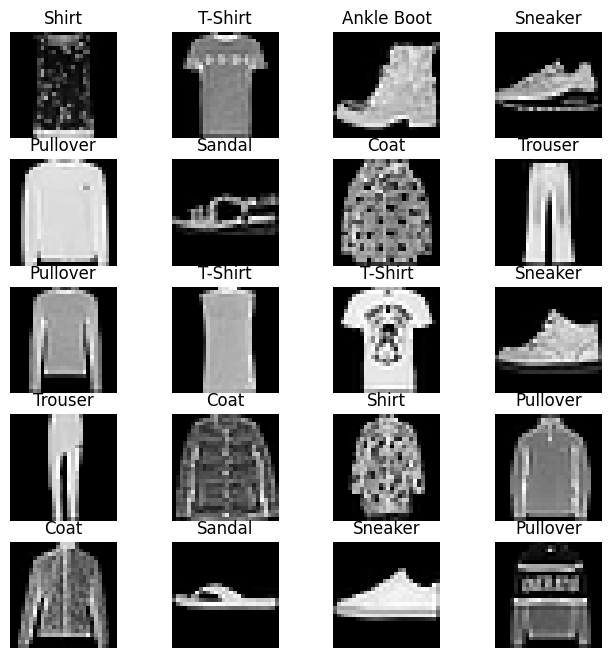

In [7]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'} # 열 개의 클래스

fig = plt.figure(figsize=(8,8)); # 출력할 이미지의 가로세로 길이 단위는 inch
columns = 4;
rows = 5;
for i in range(1,columns*rows+1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows,columns,i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img,cmap='gray')
plt.show() # 20개의 이미지 데이터를 시각적으로 표현

np.random은 무작위로 데이터를 생성할 때 사용한다.

np.random.randint()는 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용한다.

따라서 random.randint(len(train_dataset))의 의미는 0~(train_dataset의 길이) 값을 갖는 분포에서 랜덤한 숫자 한 개를 생성하라는 의미이다.

In [8]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN,self).__init__()
    self.fc1 = nn.Linear(in_features=784,out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256,out_features=128)
    self.fc3 = nn.Linear(in_features=128,out_features=10)

  def forward(self,input_data):
    out = input_data.view(-1,784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

**클래스와 함수**

함수(function)란 하나의 특정 작업을 수행하기 위해 독립적으로 설계된 프로그램 코드이다.

함수의 호출은 특정 작업만 수행할 뿐 그 결괏값을 계속 사용하기 위해서는 반드시 어딘가에 따로 그 값을 저장해야만 한다.

즉, 함수를 포함한 프로그램 코드의 일부를 재사용하기 위해서는 해당 함수뿐만 아니라 데이터가 저장되는 변수까지도 한꺼번에 관리해야 한다.

nn은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지이다.

in_features: 입력의 크기

out_features: 출력의 크기

모델을 학습시키기 전에 손실 함수, 학습률(learning rate), 옵티마이저(optimizer)에 대해 정의한다.

In [10]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


옵티마이저를 위한 경사 하강법은 Adam을 사용하여, 학습률을 의미하는 lr은 0.001을 사용한다.

이제 심층 신경망에 데이터를 적용하여 모델을 학습시킨다.

In [13]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images,labels in train_loader:
    images,labels=images.to(device),labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train) # 학습 데이터를 모델에 적용
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count%50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images,labels in test_loader:
        images,lables = images.to(device),labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs,1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct *100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,loss.data,accuracy))

Iteration: 500, Loss: 0.5962347388267517, Accuracy: 84.64167022705078%
Iteration: 1000, Loss: 0.48428305983543396, Accuracy: 85.836669921875%
Iteration: 1500, Loss: 0.370678186416626, Accuracy: 86.04666900634766%
Iteration: 2000, Loss: 0.37859049439430237, Accuracy: 86.7699966430664%
Iteration: 2500, Loss: 0.26965948939323425, Accuracy: 87.53333282470703%
Iteration: 3000, Loss: 0.2896413505077362, Accuracy: 88.41166687011719%


최종적으로 정확도가 88%로 높은 수치를 보여준다.

이제 합성곱 신경망을 생성한다.

In [18]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6,out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600,out_features=120)
    self.fc3 = nn.Linear(in_features=120,out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return(out)

nn.Sequential은 계층을사례로 쌓을 수 있도록 수식과 활성화 함수를 연결해 주는 역할을 한다.

특히 데이터가 각 계층을 순차적으로 지나갈 때 사용하면 좋다

합성곱층은 합성곱 연산을 통해 이미지의 특징을 추출한다.

합성곱이란 커널(또는 필터)이라는 nxm 크기의 행렬이 높이x너비 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력한다.

padding은 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채우는 것이다.

패딩 값이 클수록 출력 크기도 커진다.

BatchNorm2d는 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것이다.

MaxPool2d는 이미지 크기를 축소시킨다.

In [19]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


모델을 학습시킨다.

In [20]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images,labels in train_loader:
    images,labels=images.to(device),labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train) # 학습 데이터를 모델에 적용
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count%50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images,labels in test_loader:
        images,lables = images.to(device),labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs,1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct *100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,loss.data,accuracy))

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.546149730682373, Accuracy: 88.54000091552734%
Iteration: 1000, Loss: 0.3617422878742218, Accuracy: 89.47333526611328%
Iteration: 1500, Loss: 0.3150843679904938, Accuracy: 89.70166778564453%
Iteration: 2000, Loss: 0.16987977921962738, Accuracy: 91.26166534423828%
Iteration: 2500, Loss: 0.16819536685943604, Accuracy: 92.47166442871094%
Iteration: 3000, Loss: 0.20817771553993225, Accuracy: 93.09500122070312%


심층 신경망과 비교하여 정확도가 약간 높다.

심층 신경망과 별 차이가 없기 때문에 좀 더 간편한 심층 신경망만 사용해도 무난할 것 같지만 실제로 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 생성할 수 있도록 학습해야 한다.